<a href="https://colab.research.google.com/github/FinNijatTech/Deep-Learning-for-Face-Detection-ML-semester-2-/blob/main/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [19]:
SP500 = yf.download("^GSPC", start="1970-01-01", end="2022-01-01")

[*********************100%%**********************]  1 of 1 completed


In [48]:
SP500 = SP500.reset_index()

In [49]:
def Dataset(Data, Date):

  Train_Data = Data['Adj Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [123]:

def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [124]:
model = Model()

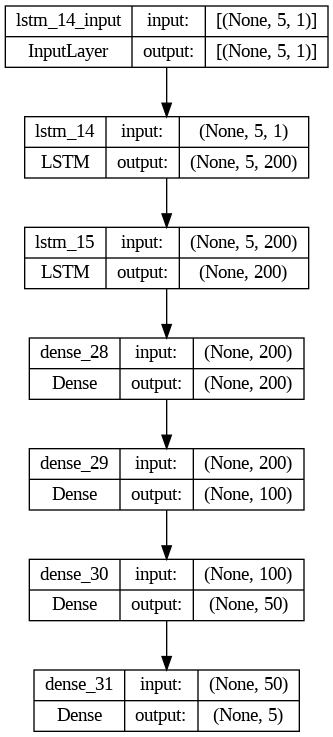

In [125]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [126]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 200)            161600    
                                                                 
 lstm_15 (LSTM)              (None, 200)               320800    
                                                                 
 dense_28 (Dense)            (None, 200)               40200     
                                                                 
 dense_29 (Dense)            (None, 100)               20100     
                                                                 
 dense_30 (Dense)            (None, 50)                5050      
                                                                 
 dense_31 (Dense)            (None, 5)                 255       
                                                                 
Total params: 548005 (2.09 MB)
Trainable params: 54800

In [127]:
def scheduler(epoch):

  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150)
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)

  return lrate

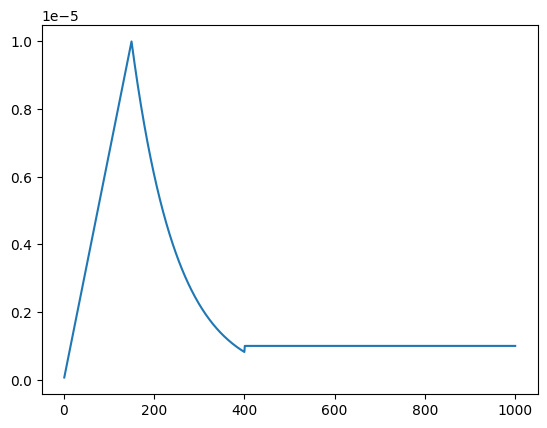

In [128]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [129]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Exploratory Data Analysis**

In [130]:
SP500.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,1970-01-02,0.0,93.540001,91.790001,93.000000,93.000000,8050000
1,1,1970-01-05,0.0,94.250000,92.529999,93.459999,93.459999,11490000
2,2,1970-01-06,0.0,93.809998,92.129997,92.820000,92.820000,11460000
3,3,1970-01-07,0.0,93.379997,91.930000,92.629997,92.629997,10010000
4,4,1970-01-08,0.0,93.470001,91.989998,92.680000,92.680000,10670000


In [131]:
SP500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13118 entries, 0 to 13117
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      13118 non-null  int64         
 1   Date       13118 non-null  datetime64[ns]
 2   Open       13118 non-null  float64       
 3   High       13118 non-null  float64       
 4   Low        13118 non-null  float64       
 5   Close      13118 non-null  float64       
 6   Adj Close  13118 non-null  float64       
 7   Volume     13118 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 820.0 KB


In [148]:
# Change Dtype of Date column
SP500["Date"] = pd.to_datetime(SP500["Date"])

Text(0, 0.5, 'Adj Close')

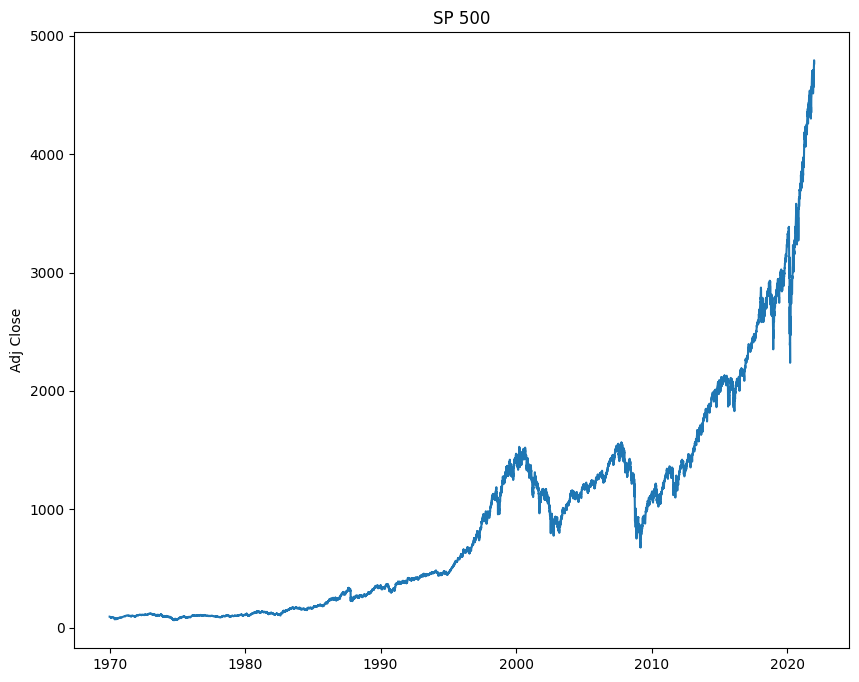

In [181]:
plt.figure(figsize=(10, 8))
plt.plot(SP500["Date"], SP500["Adj Close"])
plt.title('SP 500')
plt.ylabel('Adj Close')

Text(0, 0.5, 'Volume')

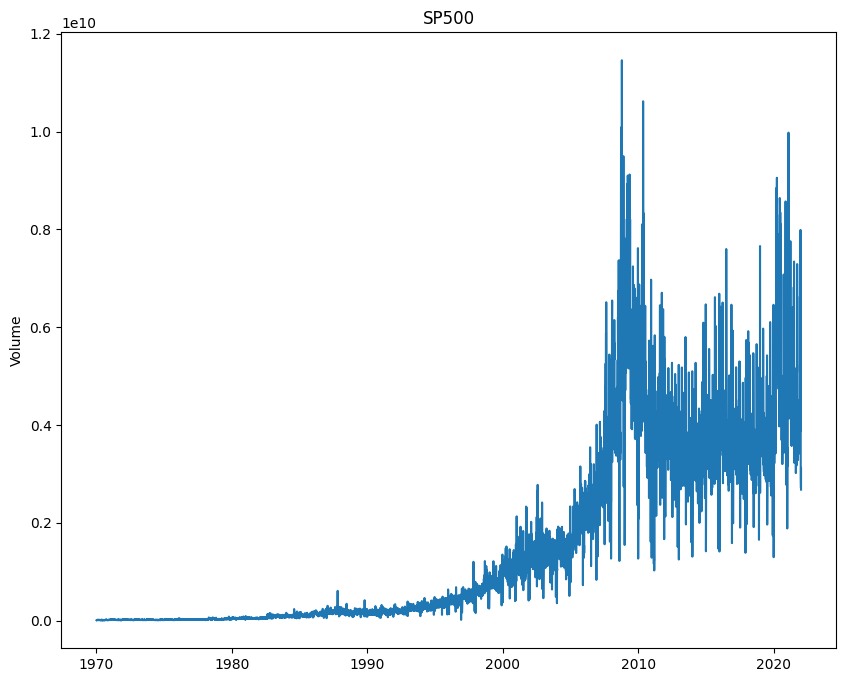

In [180]:
# Now lets plot the total volume of stock being traded each day
plt.figure(figsize=(10, 8))
plt.plot(SP500["Date"], SP500["Volume"])
plt.title('SP500')
plt.ylabel('Volume')

What was the moving average of the index ?

In [151]:
Moving_Average_Day = [10, 20, 50]
for Moving_Average in Moving_Average_Day:
    column_name = f'Moving Average for {Moving_Average} days'
    SP500[column_name] = SP500["Adj Close"].rolling(Moving_Average).mean()

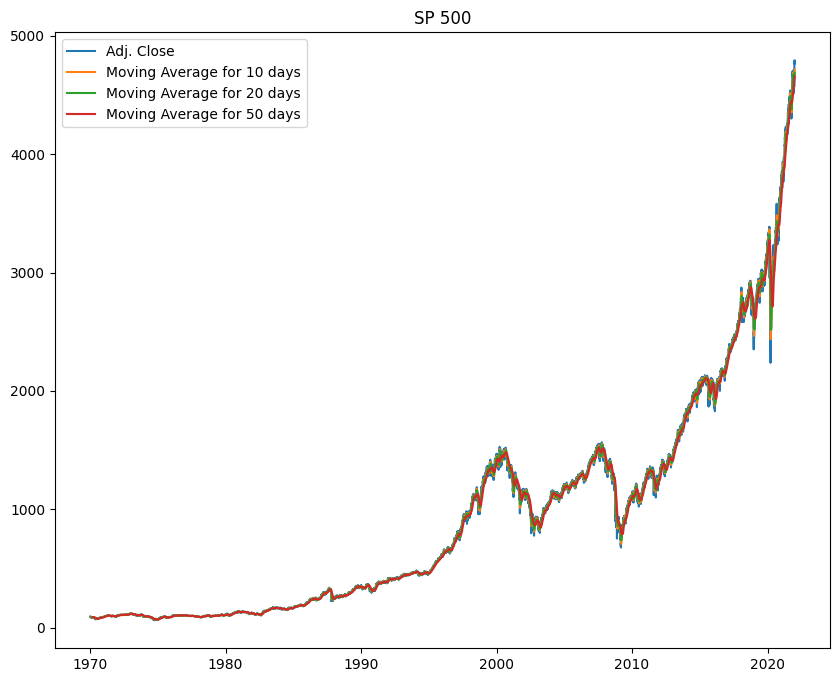

In [179]:
plt.figure(figsize=(10, 8))
plt.plot(SP500["Date"], SP500["Adj Close"])
plt.plot(SP500["Date"], SP500["Moving Average for 10 days"])
plt.plot(SP500["Date"], SP500["Moving Average for 20 days"])
plt.plot(SP500["Date"], SP500["Moving Average for 50 days"])
plt.title("SP 500")
plt.legend(("Adj. Close", "Moving Average for 10 days", "Moving Average for 20 days", "Moving Average for 50 days"))

What was the daily return of the index on average ?

In [155]:
SP500["Daily Return"] = SP500["Adj Close"].pct_change()

Text(0, 0.5, 'Daily Return')

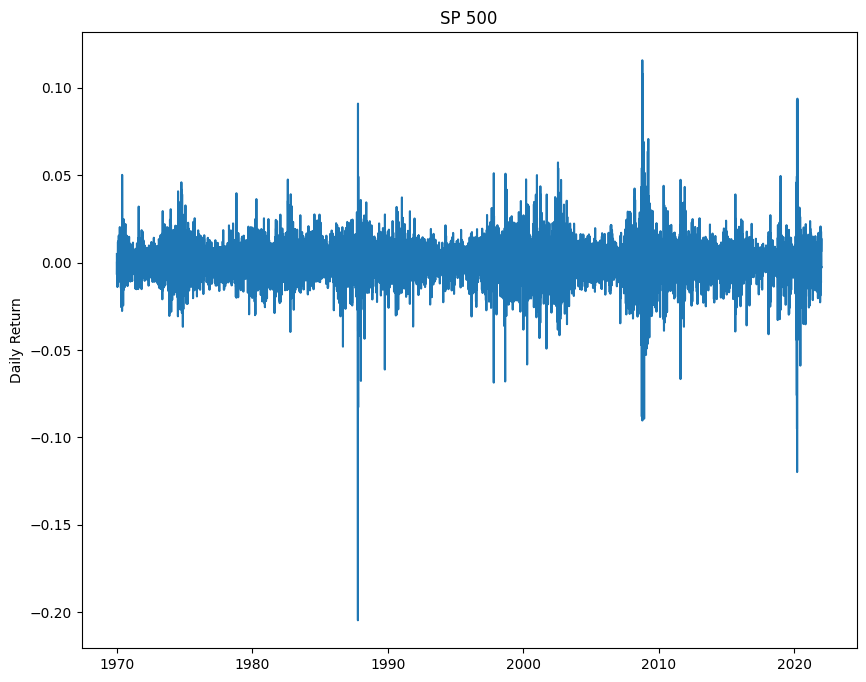

In [178]:
plt.figure(figsize=(10, 8))
plt.plot(SP500["Date"], SP500["Daily Return"])
plt.title("SP 500")
plt.ylabel('Daily Return')

Text(0.5, 1.0, 'SP 500')

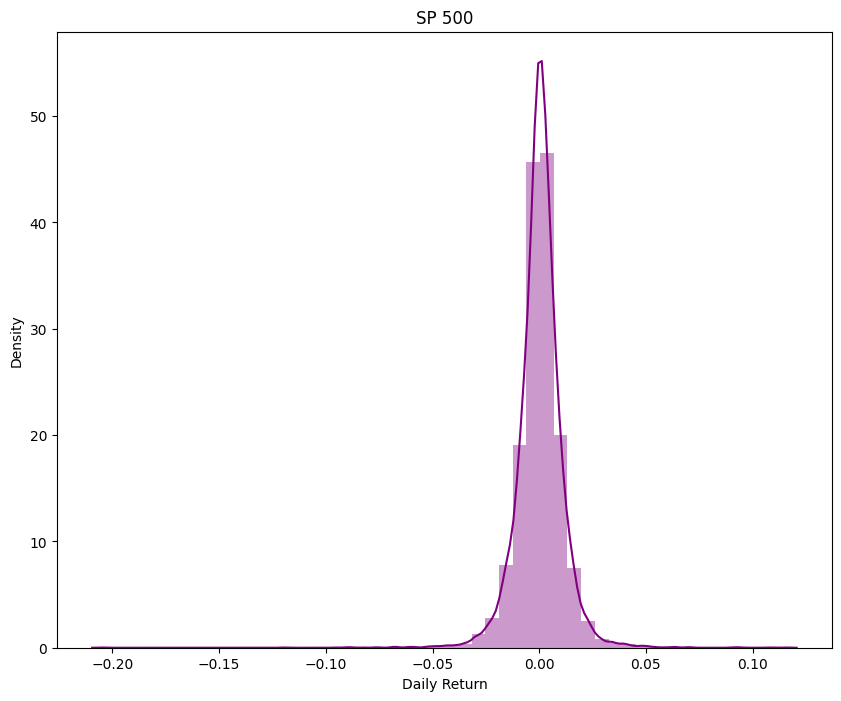

In [177]:
plt.figure(figsize=(10, 8))
sns.distplot(SP500["Daily Return"].dropna(), color = "purple")
plt.title("SP 500")

In [161]:
print("Kurtosis Value")
print(f"SP500: {SP500['Daily Return'].kurtosis()}")

Kurtosis Value
SP500: 19.64508318611838


In [162]:
SP500_returns = pd.DataFrame()
SP500_returns["SP500"] = SP500["Adj Close"]
SP_500_returns = SP500_returns.pct_change()
SP_500_returns.head()

,SP500
0,NaN
1,0.004946
2,-0.006848
3,-0.002047
4,0.000540


How much value do we put at risk by investing in SP 500 ?

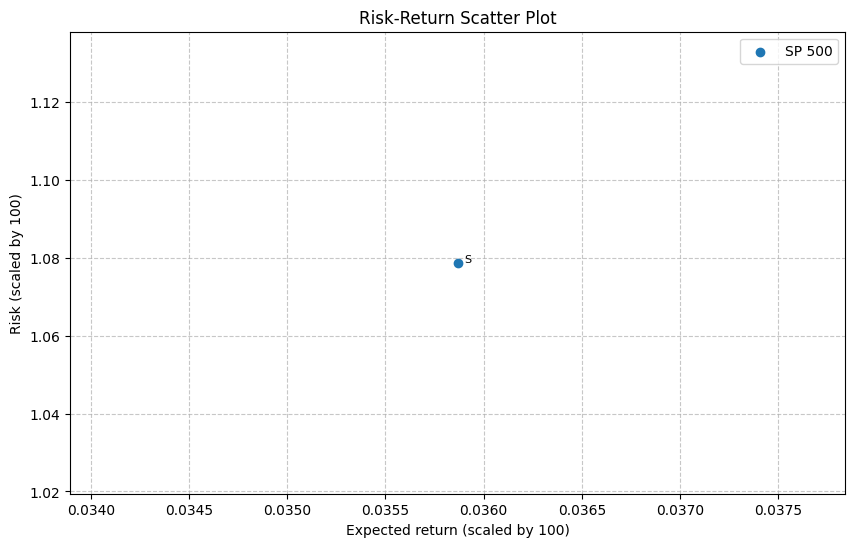

In [167]:
Returns = SP_500_returns.dropna()

# Multiply by 100 to scale up the values
scaled_mean = Returns.mean() * 100
scaled_std = Returns.std() * 100

plt.figure(figsize=(10, 6))

# Scatter plot with labels
plt.scatter(scaled_mean, scaled_std, marker='o', label='SP 500')

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Adding labels to points
for label, x, y in zip('SP 500', scaled_mean, scaled_std):
    plt.annotate(label, xy=(x, y), xytext=(10, 0), textcoords='offset points', fontsize=8, ha='right')

# Adding axis labels and title
plt.xlabel('Expected return (scaled by 100)')
plt.ylabel('Risk (scaled by 100)')
plt.title('Risk-Return Scatter Plot')

# Adding legend
plt.legend()

plt.show()


In [133]:
SP500_Date = '2020-10-01'
SP500_Train_X, SP500_Train_Y, SP500_Test_X, SP500_Test_Y = Dataset(SP500, SP500_Date)

In [134]:
SP500_Model = Model()

In [135]:
SP500_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [137]:
SP500_hist = SP500_Model.fit(SP500_Train_X, SP500_Train_Y, epochs = 260, validation_data = (SP500_Test_X, SP500_Test_Y), callbacks=[callback])

Epoch 1/260
80/80 [==============================] - 3s 31ms/step - loss: 364.5909 - root_mean_squared_error: 19.0943 - val_loss: 3931.2537 - val_root_mean_squared_error: 62.6997 - lr: 0.0000e+00
Epoch 2/260
80/80 [==============================] - 2s 31ms/step - loss: 364.4622 - root_mean_squared_error: 19.0909 - val_loss: 3968.8269 - val_root_mean_squared_error: 62.9986 - lr: 6.6667e-08
Epoch 3/260
80/80 [==============================] - 2s 31ms/step - loss: 364.0880 - root_mean_squared_error: 19.0811 - val_loss: 3993.5432 - val_root_mean_squared_error: 63.1945 - lr: 1.3333e-07
Epoch 4/260
80/80 [==============================] - 3s 33ms/step - loss: 363.4560 - root_mean_squared_error: 19.0645 - val_loss: 3969.0332 - val_root_mean_squared_error: 63.0003 - lr: 2.0000e-07
Epoch 5/260
80/80 [==============================] - 4s 49ms/step - loss: 363.2315 - root_mean_squared_error: 19.0586 - val_loss: 3955.3577 - val_root_mean_squared_error: 62.8916 - lr: 2.6667e-07
Epoch 6/260
80/80 [=

In [138]:
history_dict = SP500_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

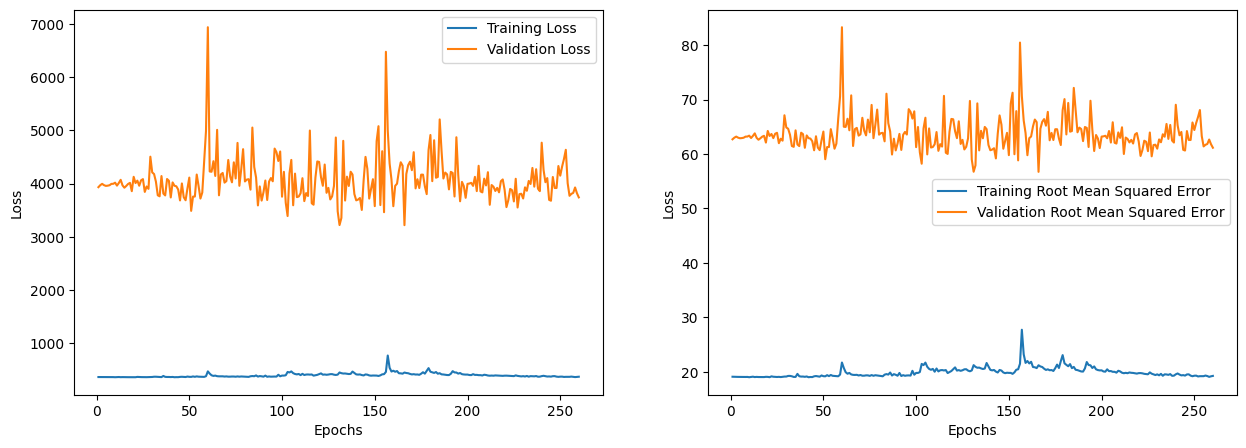

In [139]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [140]:
SP500_prediction = SP500_Model.predict(SP500_Test_X)

2/2 [==============================] - 0s 13ms/step


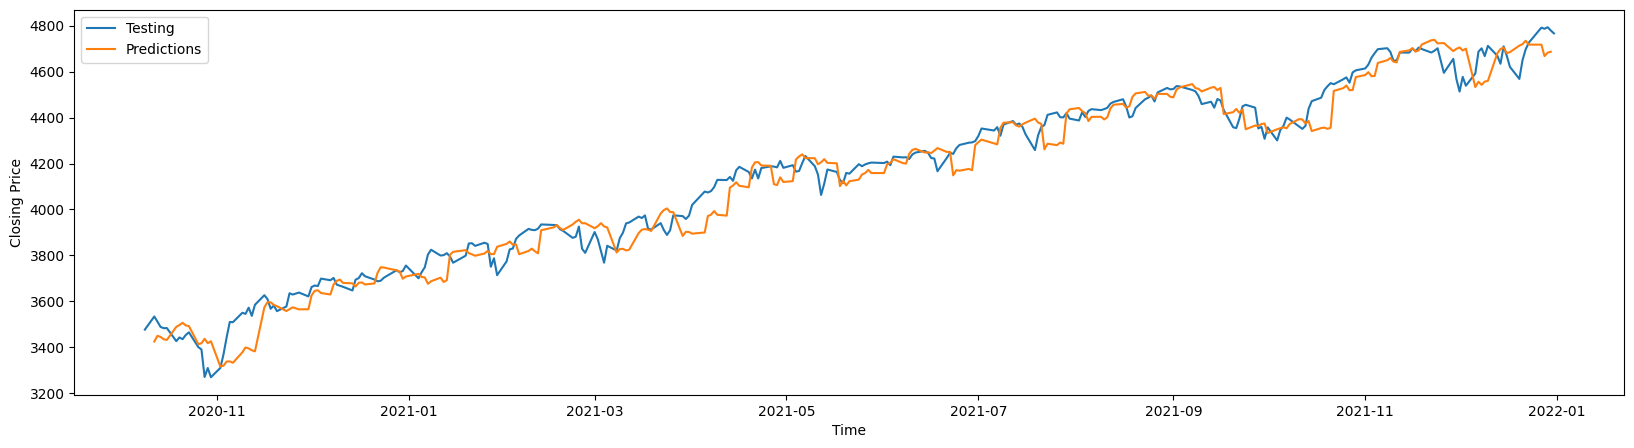

In [176]:
plt.figure(figsize=(20, 5))
plt.plot(SP500['Date'][SP500['Date'] >= '2020-10-09'], SP500['Adj Close'][SP500['Date'] >= '2020-10-09'], label='Testing')
plt.plot(SP500['Date'][SP500['Date'] >= '2020-10-12'][:-1], SP500_prediction.reshape(-1)[:-2], label='Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc='best')
plt.show()

In [171]:
# Assuming SP500_Test_Y and SP500_prediction are NumPy arrays
rmse = math.sqrt(mean_squared_error(SP500_Test_Y.reshape(-1, 5), SP500_prediction))
mape = np.mean(np.abs(SP500_prediction - SP500_Test_Y.reshape(-1, 5)) / np.abs(SP500_Test_Y.reshape(-1, 5)))
r_squared = r2_score(SP500_Test_Y.reshape(-1, 5), SP500_prediction)

# Number of observations
n = len(SP500_Test_Y.reshape(-1, 5))

# Number of features (assuming 5 features based on the reshape)
k = 5

# Calculate adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'Adjusted R-squared: {adjusted_r_squared}')

RMSE: 61.15141211661522
MAPE: 0.011573671800900708
Adjusted R-squared: 0.9719086455170821
